# Graph Theory

This notebook is a modified version of [Chapter 1 of Mining Complex Networks](https://github.com/ftheberge/GraphMiningNotebooks/blob/master/Julia_Notebooks_2nd/Chapter_1.ipynb)

In [3]:
using CSV
using DataFrames
using DelimitedFiles
using Graphs
using GLMakie, GraphMakie
using NetworkLayout
using Statistics
using PyPlot
using StatsBase
using GLM

## Summary
In this notebook, we look at **simple graph statistics** such as:
- degree distribution
- clustering coefficient
- shortest path length distribution

We illustrate the fact that even with such simple measures, we can see big difference between different types of graphs, thus the importance of **EDA**, exploratory data analysis, as a first step in data mining. 

In this notebook we consider two graphs:

- a social-type graph, links between **GitHub developers**
- a transportation-type network, namely a **power grid**

Throughout, we use the terms **vertex** and **node** interchangably. 

## GitHub Developers (undirected)

### Description

A large undirected social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. 

The graph has two types of nodes: 
- web developer
- machine learning developer

Below, we construct this graph (with `Graphs.jl` package); later we will look at subgraphs respectively for web or machine learning (ml) developers. The graph is stored in object `GitHubGraph`


In [4]:
## read the GitHub edge list into a graph
D = CSV.read("GitHubDevelopers/musae_git_edges.csv", DataFrame) .+ 1
max_node_id = max(maximum(D.id_1), maximum(D.id_2))
GitHubGraph = SimpleGraph(max_node_id)
foreach(row -> add_edge!(GitHubGraph, row...), eachrow(D))

### Node attributes

Each node has three attributes:
* it's index (as used in the edge list)
* the username
* a binary flag indicating ml or web developer (1 = ml)


In [5]:
## read node attributes
GitHub_attr = CSV.read("GitHubDevelopers/musae_git_target.csv", DataFrame)
GitHub_attr.id .+= 1
#Checking if attributes are sorted by id and if number of attributes match number of nodes
@assert issorted(GitHub_attr.id) && extrema(GitHub_attr.id) == (1, nv(GitHubGraph))
first(GitHub_attr, 3)

Row,id,name,ml_target
,Int64,String31,Int64
1,1,Eiryyy,0
2,2,shawflying,0
3,3,JpMCarrilho,1


In [6]:
## 2 class of nodes, 0: web developer (grey), 1: ml developer (black)
gh_target = GitHub_attr.ml_target
gh_color = ifelse.(gh_target .== 0, "grey", "black")
gh_lbl = ifelse.(gh_target .== 0, "web", "ml");

### GitHub subgraphs
We build the two subgraphs below: ```subgraph_ml``` for the machine learning (**ml**) developers and ```subgraph_web``` for the **web** developers.

In [7]:
## build the subgraphs
subgraph_ml = induced_subgraph(GitHubGraph, findall(==("ml"), gh_lbl))[1]
subgraph_web = induced_subgraph(GitHubGraph, findall(==("web"), gh_lbl))[1]

## there are 9739 ml developers and 27961 web developers
@show nv(GitHubGraph), nv(subgraph_ml), nv(subgraph_web);

(nv(GitHubGraph), nv(subgraph_ml), nv(subgraph_web)) = (37700, 9739, 27961)


Note that some ml developers are connected only to web developers and vice-versa.

Therefore, some nodes will end up with no connection (degree 0) in the subgraphs.

In [8]:
count_ml = sum([all(gh_target[neighbors(GitHubGraph, ml_v)] .== 0) for ml_v in findall(==(1), gh_target)])
count_web = sum([all(gh_target[neighbors(GitHubGraph, web_v)] .== 1) for web_v in findall(==(0), gh_target)])

print("$count_ml ml developers connected only to web developers\n",
      "$count_web web developers connected only to ml developers")

2308 ml developers connected only to web developers
285 web developers connected only to ml developers

In [9]:
## this should correpond to the number of degree 0 nodes in the subgraphs,
## as there are no degree 0 nodes in the original graph.
println("nodes of degree zero in overall graph=> $(sum(x -> x==0, degree(GitHubGraph)))")
println("nodes of degree zero in ml subgraph=> $(sum(x -> x==0, degree(subgraph_ml)))")
println("nodes of degree zero in web subgraph=> $(sum(x -> x==0, degree(subgraph_web)))")

nodes of degree zero in overall graph=> 0
nodes of degree zero in ml subgraph=> 2308
nodes of degree zero in web subgraph=> 285


## Europe Electric Grid

A network of high voltage grid in Europe. The vertices are stations and the edges are the lines connecting them.
More details can be found at: https://zenodo.org/record/47317#.Xt6nzy3MxTY.

The graph is stored in object ```Grid```.

The edges have directionality, but for this notebook, we consider an undirected version of this graph.

Nodes have different attributes, including longitude and latitude; we will use those to force a graph layout for plotting according to the geographical location. There are several types of nodes: 'joint', 'merge', 'plant', 'station', 'sub_station', 'substation'.

### Node attributes

In [10]:
Grid_attr = CSV.read("GridEurope/gridkit_europe-highvoltage.vertices", DataFrame);
n = length(Grid_attr.v_id)
vertex_map = Dict(Grid_attr.v_id .=> 1:n)
Grid_attr.id = [vertex_map[e] for e in Grid_attr.v_id]
sort!(Grid_attr, :id)
## save longitude, latitude and node type in separate vectors
gr_longitude = Grid_attr.lon
gr_latitude = Grid_attr.lat
gr_type = Grid_attr.typ;

### Graph creation from edgelist

In [11]:
edge_list = readdlm("GridEurope/gridkit_europe-highvoltage.edges", Int)
Grid = SimpleGraph(n)
for (from, to) in eachrow(edge_list)
    add_edge!(Grid, vertex_map[from], vertex_map[to])
end
println("number of nodes: $(nv(Grid))")
println("number of edges: $(ne(Grid))")

number of nodes: 13871
number of edges: 17277


In [12]:
# EDA - min/max latitude and longitude and node types
println("Node types and counts: ", ["$k=$v " for (k, v) in countmap(gr_type)]...)
println("Latitude range: $(minimum(gr_latitude)) to $(maximum(gr_latitude))")
println("Longitude range: $(minimum(gr_longitude)) to $(maximum(gr_longitude))")

Node types and counts: merge=955 joint=6398 station=760 sub_station=736 plant=120 substation=4902 
Latitude range: 36.0323467199753 to 69.9063464171393
Longitude range: -22.0189015599842 to 44.9822753668307


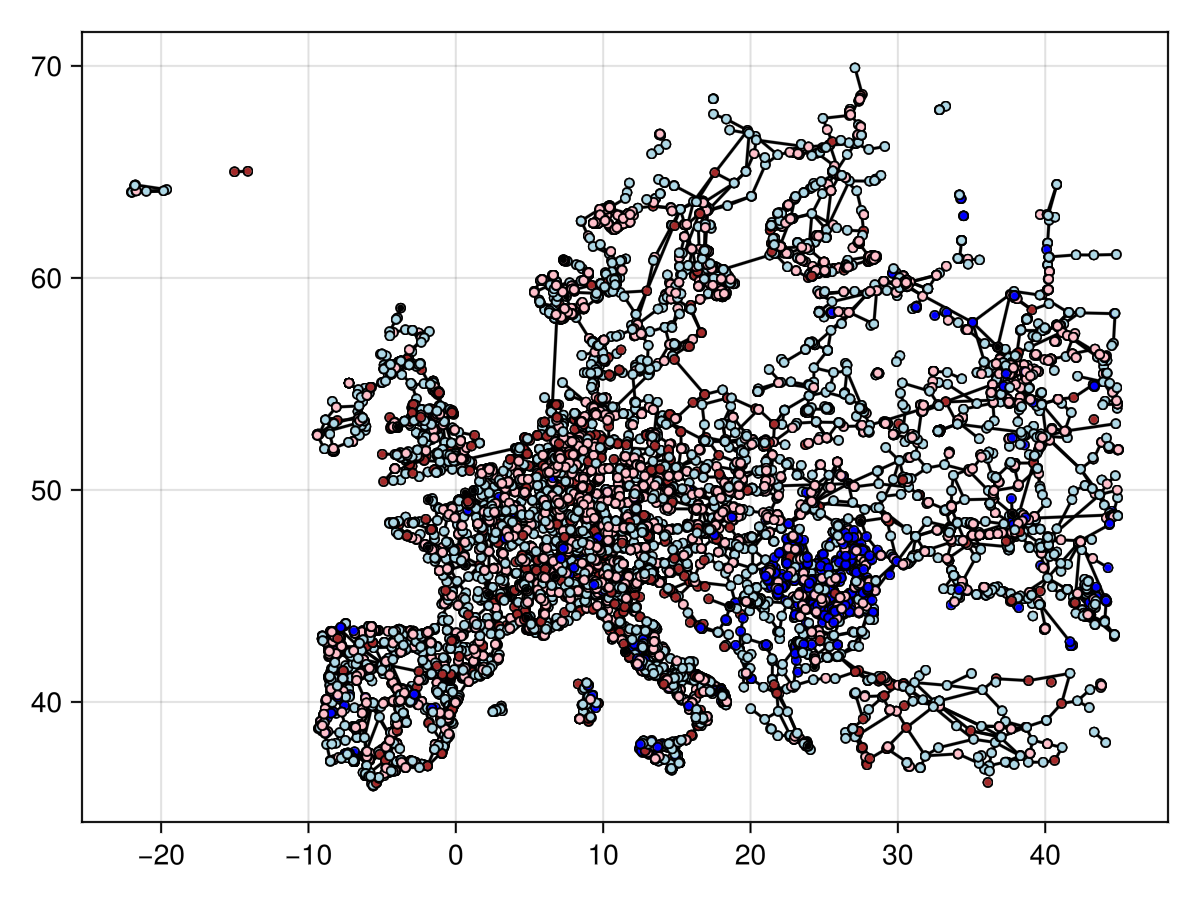

In [13]:
colors = Dict("joint" => :pink,
    "substation" => :lightblue,
    "merge" => :brown,
    "station" => :blue,
    "sub_station" => :lightblue,
    "plant" => :black)
colors_vec = [colors[t] for t in gr_type];
graphplot(Grid;
    layout=_ -> zip(gr_longitude, gr_latitude),
    node_color=colors_vec,
    node_size=5,
    node_strokewidth=1)

## Features for 4 graphs

Below, we compute several basic features for the 4 graphs we have:
- ```GitHubGraph``` (ml+web)
- ```subgraph_ml``` (GitHub ml developers subgraph)
- ```subgraph_web``` (GitHub web developers subgraph)
- ```Grid``` (Europe power grid)

Please refer to the book for details of those features.
Note that running the cell below can take a few minutes.


In [14]:
function igraph_diameter(G)
    ccs = connected_components(G)
    ccg = [induced_subgraph(G, cc)[1] for cc in ccs]
    maximum(maximum(maximum(gdistances(g, i)) for i in vertices(g)) for g in ccg)
end

igraph_diameter (generic function with 1 method)

In [15]:
## compute and store basic stats in a table
function baseStats(G)
    deg = degree(G)
    cc = connected_components(G)
    return Any[nv(G), ne(G),
        minimum(deg), mean(deg), median(deg), quantile(deg, 0.99), maximum(deg),
        length(cc), maximum(length, cc), count(==(0), deg),
        global_clustering_coefficient(G),
        mean(local_clustering_coefficient(G)[degree(G).>1])]
end

df = DataFrame(statistic=["nodes", "edges", "d_min", "d_mean", "d_median", "d_quant_99", "d_max",
        "components", "largest", "isolates", "C_glob", "C_loc"],
    GitHub=baseStats(GitHubGraph), GitHub_ml=baseStats(subgraph_ml), GitHub_web=baseStats(subgraph_web), Grid=baseStats(Grid))

## this can take a few minutes
gh_diam = igraph_diameter(GitHubGraph)
gh_ml_diam = igraph_diameter(subgraph_ml)
gh_web_diam = igraph_diameter(subgraph_web)
gr_diam = igraph_diameter(Grid)
push!(df, ("diameter", gh_diam, gh_ml_diam, gh_web_diam, gr_diam))

df

Row,statistic,GitHub,GitHub_ml,GitHub_web,Grid
,String,Any,Any,Any,Any
1,nodes,37700,9739,27961,13871
2,edges,289003,19684,224623,17277
3,d_min,1,0,0,0
4,d_mean,15.3317,4.0423,16.0669,2.4911
5,d_median,6.0,2.0,6.0,2.0
6,d_quant_99,138.01,39.0,145.0,8.0
7,d_max,9458,482,8194,16
8,components,1,2466,297,86
9,largest,37700,7083,27653,13478


### Analysis of the results

What do we see in the table above?

First, look at the **degree distribution**; the GitHub graphs have a wide range of values, including some very high degree nodes, while the Grid graph has degree in range 0 to 16 only.

The **diameter** (maximum shortest path length) is also quite different; it is common for social networks to have relatively small diameter. On the other hand, a multi-country power grid has large diameter.

Looking at **components**, the GitHub graph is connected (single component), but the two subgraphs are not, and there are even nodes with null degree as we already saw. The Grid graph has several components, but most nodes fall is what we call the "giant component".

Finally, we see some differences between the local and global **clustering coefficients** for the GitHub graphs; why is this so? what happens with very high degree nodes? See the plot below ...

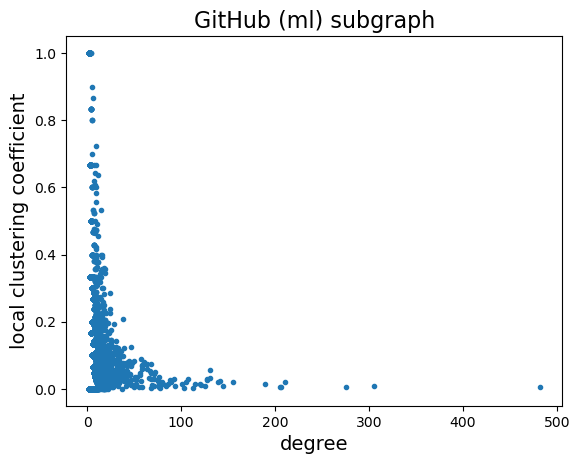

In [16]:
X = [x for x in degree(subgraph_ml) if x > 1]
Y = local_clustering_coefficient(subgraph_ml)[degree(subgraph_ml).>1]
PyPlot.plot(X, Y, ".")
title("GitHub (ml) subgraph", fontsize=16)
xlabel("degree", fontsize=14)
ylabel("local clustering coefficient", fontsize=14);


## Visualize part of the Grid network
For the Grid graph, we select a range of lat/lon that correspond to the Iberic peninsula.


showing 1563 nodes and 1980 edges


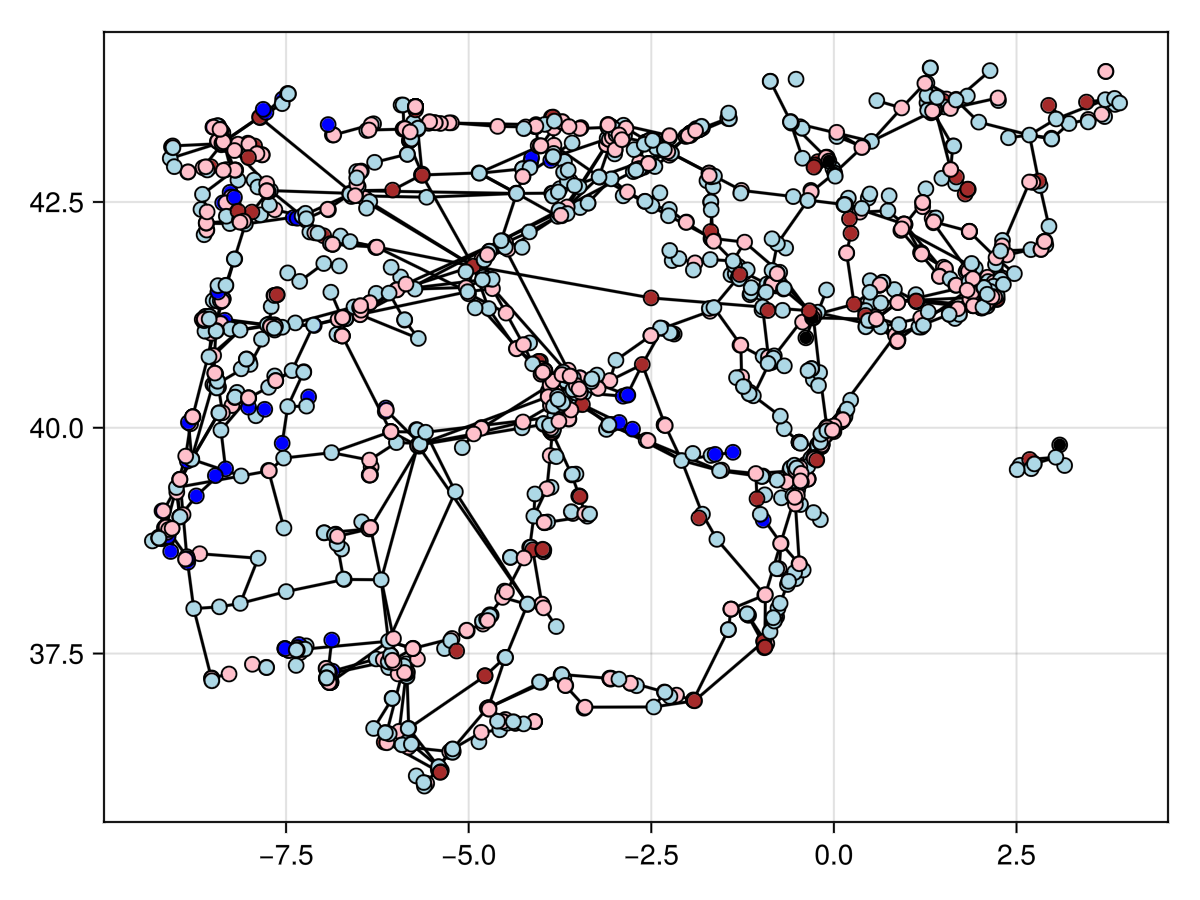

In [17]:
gr_spain, spain_ids = induced_subgraph(Grid, findall(@. (36 < gr_latitude < 44) & (-10 < gr_longitude < 4)))
println("showing $(nv(gr_spain)) nodes and $(ne(gr_spain)) edges")
graphplot(gr_spain, layout=_ -> zip(gr_longitude[spain_ids], gr_latitude[spain_ids]),
    node_color=colors_vec[spain_ids],
    node_strokewidth=1)

## Visualize part of the GitHub (ml) graph

There is no lat/lon here; in the code below, we take the giant component for the GitHub ml subgraph,
and arbitrary cut w.r.t. the computed layout to display a portion of the subgraph.

This is for illustration only; note that this is quite different from the Grid graph, with clumps (dense areas) and less regular edge distribution.

In [ ]:
function giant_component(g)
    c = connected_components(g)
    _, i = findmax(length.(c))
    g[c[i]]
end

In [ ]:
giant_ml = giant_component(subgraph_ml)

In [ ]:
# you can use other layouts if you want to experiment
locs = NetworkLayout.spring(giant_ml, iterations=10);
locs_x = getindex.(locs, 1)
locs_y = getindex.(locs, 2)

In [ ]:
# we cut the positions
xmin, xmax = quantile(locs_x, [0.4, 0.6])
ymin, ymax = quantile(locs_y, [0.4, 0.6]);
ml_zoom, ml_zoom_ids = induced_subgraph(giant_ml, findall(@. (xmin < locs_x < xmax) & (ymin < locs_y < ymax)))
println("showing $(nv(ml_zoom)) nodes and $(ne(ml_zoom)) edges")
graphplot(giant_component(ml_zoom),
    node_strokewidth=1,
    edge_color=:grey)

## Compare degree distributions

Degree distribution is one of the fundamental properties of networks. Below, we plot the empirical cumulative distribution functions (cdf) of the degree distribution for the GitHub and Grid graphs. 

As we noted before, for the GitHub graph, most nodes have low degree, but a few have very high degree, up to almost 10,000. This is not at all the case with the Grid graph where almost all nodes having degree less than 10, and the maximum degree observed is only 16.

In [ ]:
## degree distribution - GitHub graph
deg = degree(GitHubGraph)
e = ecdf(deg)
x = range(extrema(e)..., step=1)
y = e.(x)
## plot on log scale for x-axis
semilogx(x, y, "-", color="black", label="GitHub")
xlabel("degree", fontsize=14)
ylabel("empirical cdf", fontsize=14)
title("GitHub graph (ml and web developers)");

In [ ]:
## degree distribution - Grid graph
## we see much lower degrees in ths case
deg = degree(Grid)
e = ecdf(deg)
x = range(extrema(e)..., step=1)
y = e.(x)
semilogx(x, y, "-", color="black", label="Grid")
xlabel("degree", fontsize=14)
ylabel("empirical cdf", fontsize=14)
title("Power Grid Network");

## Shortest paths distribution

In the plots below, we consider 100 randomly chosen nodes, and compute the length of the shortest path to reach every other node. We then plot histograms for those values. 

Once again we see much different distributions: for the GitHub graph, most paths are quite short, with common values in the range from 2 to 6.
For the Grid graph however, the paths are generally longer, and over a much wider range.

In [ ]:
## shortest paths length from a given node, GitHub graph
cc_gh = connected_components(GitHubGraph)
giant_gh, _ = induced_subgraph(GitHubGraph, cc_gh[argmax(length.(cc_gh))])
V = sample(1:nv(giant_gh), 100, replace=false)
sp = DataFrame(len=reduce(vcat, gdistances.(Ref(giant_gh), V)))
histdata = combine(groupby(sp, :len, sort=true), nrow => :count)[2:end, :]

fig, ax = subplots()
ax.bar(histdata.len, histdata.count, color="darkgrey")
ax.set_yscale("log")
ax.set_xlabel("path length", fontsize=14)
ax.set_ylabel("number of paths (log scale)", fontsize=14)
title("GitHub graph (ml and web developers)");

In [ ]:
## min path length from that node to other nodes, Grid network
cc_gr = connected_components(Grid)
giant_gr, _ = induced_subgraph(Grid, cc_gr[argmax(length.(cc_gr))])
V = sample(1:nv(giant_gr), 100, replace=false)
V = 1:100
sp = DataFrame(len=reduce(vcat, gdistances.(Ref(giant_gr), V)))
histdata = combine(groupby(sp, :len, sort=true), nrow => :count)[2:end, :]

fig, ax = subplots()
ax.bar(histdata.len, histdata.count, color="darkgrey")
ax.set_xlabel("path length", fontsize=14)
ax.set_ylabel("number of paths", fontsize=14)
title("Power Grid Network");

## Local clustering coefficient

Below, we compare the average local clustering coefficients as a function
of the node degrees for the GitHub graph. We consider degrees from 10 to 1000.

Looking at a log-log plot, we see a power law relation between those quantities; 
we also compute the regression line for comparison.


In [ ]:
## build dataframe with degrees and local clustering coefficients
## and compute mean values w.r.t. degree.
## GitHub graph
mindeg = 10
maxdeg = 1000

D = DataFrame(CC=local_clustering_coefficient(GitHubGraph, 1:nv(GitHubGraph)), d=degree(GitHubGraph))
D_mean = combine(groupby(D, :d, sort=true), :CC => mean => :CC)
filter!(:d => x -> 10 <= x <= 1000, D_mean)
transform!(D_mean, :d => ByRow(log) => :x, :CC => ByRow(log) => :y)
model = lm(@formula(y ~ x), D_mean)

In [ ]:
## plot on log-log scale
b, a = coef(model)
loglog(D_mean.d, D_mean.CC, ".-", color="grey")
PyPlot.plot([mindeg, maxdeg], [exp(b) * mindeg^a, exp(b) * maxdeg^a], color="black")
xlabel("log(degree)", fontsize=14)
ylabel("log(mean local clust. coef.)", fontsize=14);
title("GitHub graph (ml and web developers)");